In [1]:
library(tidyverse)
library(matrixStats)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [2]:
##########################
# Some helper functions
#########################
eps <- 1e-5

# function to compute inner norm of a vector
inner.norm <- function(x) sqrt(sum(x^2))

# function to compute inner product of two vectors
inner.prod <- function(x, y) sum(x*y)

# function to normalize a vector
normalize.vec <- function(x, eps = 1e-10) {
  n <- inner.norm(x)
  if (n < eps) {
    return(rep(1, length(x)) / sqrt(length(x)))
  } else {
    return(x / n)
  }
}


# matrix square root function of symmetric matrices, or inverse square root
matsq <- function(X, inverse = FALSE) {
  s <- svd(X)
  evals.sq <- ifelse(s$d > 0, ifelse(inverse, s$d^(-0.5), s$d^0.5), 0)
  return(tcrossprod( t(t(s$u) * evals.sq), s$v ))
}

# folded normal distribution related normalizing function C_t(z)
folded.crit <- function(t, z) {
  if (t <= 1) {
    stop("Invalid value of t")
  }
  return((z - (log(log(t)) + log(4 * pi))/2) / sqrt(2 * log(t)))
}

# inverse of folded normal critical value find z such that C_t(z) = X
inv.folded.crit <- function(t, x) {
  if (t <= 1) {
    stop("Invalid value of t")
  }
  return(x * sqrt(2 * log(t)) + (log(log(t)) + log(4*pi))/2)
}

## Estimation Functions

In [3]:
#####################
# Estimator Functions

# function to get the kernel matrix
kern <- function(x1, x2, nloc, distmat = NULL) {
  #' @param x1 first data-point of the covariate
  #' @param x2 second data-point of the covariate. The kernel will be calculated based on these two points.
  #' @param nloc the number of spatial points
  #' @param distmat distance matrix between the spatial points (if available)
  
  if (is.null(distmat)) {
    return(exp(-0.1 * sum((x1 - x2)^2)) * exp(-0.1 * outer(1:nloc, 1:nloc, FUN = "-")^2))
  } else {
    return(exp(-0.1 * sum((x1 - x2)^2)) * exp(-0.1 * distmat))
  }
} 

# function to estimate quantile from a given data
estimate.quantile <- function(Y, Xt, Z = NULL, quant = 0.5, x = colMedians(Xt), maxiter = 1000, tol = 1e-5) {
  
  #' @param Y data-matrix of the response variable
  #' @param Xt data-matrix of the covariate process 
  #' @param Z latitude-longitude information (if available)
  #' @param quant which quantile to work on, default is median (0.5)
  #' @param x value at which the estimate needs to be obtained, default is sample median
  #' @param maxiter maximum number of iterations to run the algorithm, default 1000
  #' @param tol tolerance for convergence
  
  # get the dimensions of the data
  ntime <- nrow(Y)
  nloc <- ncol(Y)
  
  # check if the data fits the required setting for theoretical gurantee
  alpha <- log(nloc) / log(ntime)
  if (alpha > 1/2) {
    warning("The number of locations are higher than expected, theoretical gurantees may not be accurate.")
  }
  
  # bandwidth specification
  beta <- 1.5 * alpha - 1
  nbn <- ntime^(-beta)
  
  eps <- 1e-10  # tolerance level for matrix inversion and conditioning
  
  # get distance matrix based on available info about locations
  if (is.null(Z)) {
    distmat <- NULL
  } else {
    distmat <- as.matrix(dist(Z))
  }

  # calculate the kernal values for all Xt
  kern.array <- lapply(c(1:ntime), FUN = function(j) kern(Xt[j,], x, nloc, distmat))
  kern.norm <- unlist(lapply(kern.array, FUN = function(x1) norm(x1)))
  
  # find the closest x-index for every observation
  best.index <- which.max(kern.norm)
  
  # initialization of the algorithm
  init.u <- ntime + runif(nloc)
  init.u <- init.u/inner.norm(init.u) * (2 * quant - 1)
  est.mean <- numeric(nloc)
  est.var <- matrix(0, nrow = nloc, ncol = nloc)
  
  # preliminary settings for the iterative algorithm
  niter <- 0
  converged <- FALSE
  err <- Inf
  q <- runif(nloc)
  
  # calculations that are needed several times
  idx = which((abs(1:ntime - best.index) < nbn) & (kern.norm > eps))  # apply the kernel to the support specified by the bandwidth
  kmats = kern.array[idx]
  Ymat = Y[idx,]
  dim(Ymat) <- c(length(idx), nloc)
  mean.calc = lapply(1:length(idx),FUN = function(x1) (kmats[[x1]] %*% Ymat[x1,]))
  var.calc = lapply(1:length(idx),FUN = function(x1) tcrossprod(mean.calc[[x1]], Ymat[x1,]))
  
  wmat = Reduce('+', kmats)
  add.mean = Reduce('+', mean.calc)
  add.var = Reduce('+', var.calc)
  wmat.inv <- solve(wmat + eps*diag(nloc))
  
  # run the algorithm until convergence
  while (!converged) {
    
    est.mean <- add.mean
    est.var <- add.var
    rhs.term = est.mean + est.var %*% init.u / 2
    qnew <- wmat.inv %*% rhs.term
    
    # error calculation
    err <- sqrt(sum((q - qnew)^2)) / sqrt(sum(q^2))
    q <- qnew
    niter <- niter + 1
    
    # convergence check
    if ((niter > maxiter) | (err < tol)) {
      converged <- TRUE
    }  
  }
  
  # return the estimated quantile
  return(list(
    "q" = qnew
  ))
}

estimate.sigma <- function(Y, Xt, Z = NULL, x = colMedians(Xt)) {
  
  #' @param Y data-matrix of the response variable
  #' @param Xt data-matrix of the covariate process 
  #' @param Z latitude-longitude information (if available)
  #' @param x value at which the estimate needs to be obtained, default is sample median
  
  # get the dimensions of the data and some initial parameters
  ntime <- nrow(Y)
  nloc <- ncol(Y)
  alpha <- log(nloc) / log(ntime)  
  beta <- 1.5 * alpha - 1
  nbn <- ntime^(-beta)
  
  if (is.null(Z)) {
    distmat <- NULL
  } else {
    distmat <- as.matrix(dist(Z))
  }
  kern.array = lapply(c(1:ntime), FUN = function(j) kern(Xt[j,], x, nloc, distmat))
  kern.norm <- unlist(lapply(kern.array, FUN = function(x1) norm(x1)))
  best.index <- which.max(kern.norm)
  idx = which((abs(1:ntime - best.index) < nbn) & (kern.norm > eps))  # apply the kernel to the support specified by the bandwidth
  
  # estimating sigma using nonparametric method using kernel smoothing
  var.calc <- lapply(1:length(idx),FUN = function(i) (kern.array[[idx[i]]] %*% tcrossprod(Y[idx[i],])) )
  var.est <- solve(Reduce('+', kern.array[idx]) + 1e-10*diag(nloc), Reduce('+', var.calc))  
  return(var.est)
}

## Testing Functions

In [4]:

###################
# Testing Function

# estimate required quantities for testing of hypotheses given a dataset
calc.for.tests <- function(q0, Y, Xt, mu_list, sigma_list, Z = NULL, x = colMedians(Xt), normalize = TRUE) {
  
  #' @param q0 the quantile vector at which eta_t(q_0) is to be calculated 
  #' @param Y data-matrix of the response variable
  #' @param Xt data-matrix of the covariate process 
  #' @param mu_list A list of estimate mu(hat) at each timepoint
  #' @param sigma_list A list of estimate sigma(hat) at each timepoint
  #' @param Z latitude-longitude information (if available)
  #' @param x value at which the estimate needs to be obtained, default is sample median
  #' @param normalize should we divide by npb_n?

  # get the dimensions of the data and some initial parameters
  ntime <- nrow(Y)
  nloc <- ncol(Y)
  alpha <- log(nloc) / log(ntime)  
  beta <- 1.5 * alpha - 1
  nbn <- ntime^(-beta)
  eps <- 1e-4
  
  if (is.null(Z)) {
    distmat <- NULL
  } else {
    distmat <- as.matrix(dist(Z))
  }
  kern.array <- lapply(c(1:ntime), FUN = function(j) kern(Xt[j,], x, nloc, distmat))
  kern.norm <- unlist(lapply(kern.array, FUN = function(x1) norm(x1)))
  best.index <- which.max(kern.norm)
  idx = which((abs(1:ntime - best.index) < nbn) & (kern.norm > eps))  # apply the kernel to the support specified by the bandwidth
  
  mu0hat <- estimate.quantile(Y, Xt, Z, 0.5, x)[["q"]]
  muhat <- t(sapply(idx, FUN = function(i) (mu_list[[i]]) ))
    # transposing ensures each row corresponds to a timepoint

  # calculating eta_t 
  eta <- t(sapply(1:length(idx),FUN = function(i) {
      return(kern.array[[idx[i]]] %*% (muhat[i, ] - q0))
  }))
  mu_minus_q0 <- (mu0hat - q0)
  etavec <- t(sapply(1:length(idx),FUN =  function(i){
    return(normalize.vec(mu_minus_q0) - normalize.vec(eta[i,]))
  })) # each row corresponds to a timepoint
  term.calc1 = lapply(1:length(idx),FUN = function(i) (kern.array[[idx[i]]] %*% etavec[i,] ))
  
  # calculating Psi_t through eta and V2 as in Eq (14)
  v2 <- lapply(1:length(idx), FUN = function(i) {
    etanorm <- inner.norm(eta[i, ])  # norm value || eta(t_i) ||
    if (etanorm > eps) {
      return((diag(nloc) - outer(eta[i, ], eta[i, ])/ etanorm^2)/etanorm)
    } else {
      return((diag(nloc) -  matrix(1/nloc, nrow = nloc, ncol = nloc)))  # handle very small eta values
    }
  })
  term.calc2 <- lapply(1:length(idx),FUN = function(i) (kern.array[[idx[i]]] %*% v2[[i]] %*% kern.array[[idx[i]]] ))
  
  # use previous quantities to estimate the sigma via the term K V2 V1 V2 K
  KV2K <- term.calc2
  sigmas <- lapply(1:length(idx), FUN = function(i) (sigma_list[[idx[i]]]) )
  term.calc3 <- lapply(1:length(idx), FUN = function(i) (KV2K[[i]] %*% sigmas[[i]] %*% KV2K[[i]]) )
    
  if (normalize) {
    eta = Reduce('+', term.calc1) / (nloc*nbn)
    Psi = Reduce('+', term.calc2) / (ntime)
    Omega = Reduce('+', term.calc3) / (nloc^2*nbn^2)
  } else {
    eta = Reduce('+', term.calc1)
    Psi = Reduce('+', term.calc2)
    Omega = Reduce('+', term.calc3)
  }
  
  return(list(
    eta = eta,
    Psi = Psi,
    Omega = Omega
  ))


}


##########################
# H0: Some restrictions on Q

# function to test any general hypothesis
test.quantile <- function(Y, estimate.H0, Xt = NULL, Z = NULL, quant = 0.5, est.quant = NULL, tgap = 1, sig.level = 0.05, verbose = TRUE) {
  #' @param Y data-matrix of the response variable
  #' @param estimate.H0 a function that takes input (Y, Xt, current_quantile, Z, quant) => quantile_under_H0 by applying the restrictions
  #' @param Xt data-matrix of the covariate variable (if not available, takes the timepoints)
  #' @param Z latitude-longitude information (if available)
  #' @param quant which quantile to work on, default is median (0.5)
  #' @param est.quant estimated quantile matrix if it has been already computed
  #' @param tgap the supremum is taken over a sequence of timepoints only, tgap is the stepsize in this sequence
  #' @param sig.level the significance level at which the hypothesis is to be rejected
  #' @param verbose whether to print progress bar or not
  
  # initialize some parameters
  ntime <- nrow(Y)
  nloc <- ncol(Y)
  alpha <- log(nloc) / log(ntime)  
  beta <- 1.5 * alpha - 1
  bn <- ntime^(-1-beta)
  eps <- 1e-5
  
  if (is.null(Xt)) {
    Xt <- matrix(c(1:ntime)/ntime, ncol = 1)  # only one covariate is time
  }
  
  # find the estimator at each time point
  if (is.null(est.quant)){
    quantiles <- matrix(NA, nrow = ntime, ncol = nloc)  # to hold the quantiles
    for (i in 1:ntime) {
      quantiles[i, ] <- estimate.quantile(Y, Xt, Z, quant, x = Xt[i,])[["q"]]
    }
  } else {
    quantiles <- est.quant
  }
  
  # estimate of quantiles under H0
  q0s <- estimate.H0(Y, Xt, quantiles, Z, quant)  # returns (ntime, nloc) matrix

  # estimate mu(hat) and sigma(hat) at each location
  mu_list = lapply(1:ntime, FUN = function(i) { estimate.quantile(Y, Xt, Z, 0.5, Xt[i, ])[["q"]] } )
  sigma_list = lapply(1:ntime, FUN = function(i) { estimate.sigma(Y, Xt, Z, Xt[i,]) } )
    
  # computation for the test statistic
  testmat.sig = numeric(ntime)
    if (verbose) {
          pb = txtProgressBar(min = 0, max = ntime, style = 3)        
    }
  for(i in seq(1, ntime, by = tgap)){
    
    # ignore normalization factors for now, leads to better numerical stability
    # compute the eta_t, psi_t, omega_t as in Eq. (15), (16) and (17)
    out = calc.for.tests(q0 = quantiles[i, ], Y, Xt, mu_list, sigma_list, Z, x = Xt[i,], normalize = FALSE)
    eta_ts <- out$eta
    psi_ts <- out$Psi
    omega_ts <- out$Omega
    
    # the mu_q vector, mean of gaussian process
    mu_q <- solve(psi_ts + diag(nloc), eta_ts)
    mu_q <- mu_q * eps * inner.norm(quantiles[i,]) / inner.norm(mu_q) 
    
    # sigma_q^{-1/2}, where sigma_q is the covariance of the gaussian process
    sigma_q.invsq <- tcrossprod(
      matsq(psi_ts) %*% matsq(omega_ts + eps * diag(nloc), inverse = TRUE), 
      matsq(psi_ts)
    )
            
    # create the test matrix for i-th timepoint
    testmat <- tcrossprod(sigma_q.invsq %*% (quantiles[i,] - q0s[i,] - mu_q / (nloc * bn)) )  
    
    # largest singular value of the test matrix
    testmat.sig[i] = norm(testmat, type = "2") / (ntime * nloc)
      
      if (verbose) {
    setTxtProgressBar(pb, value = i)          
      }
  }
    if (verbose) {
  close(pb)        
    }

  # final adjustment to test statistic for normalization for the ignored normalization
  teststat <- max(testmat.sig[testmat.sig > 0]) * (nloc * bn)  
  
  # calculate the p-value
  m_n <- exp((nloc * bn)^(-2))
  gumbel_crit <- inv.folded.crit(m_n, teststat - sqrt(2 * log(m_n)))
  pval <- 1 - exp(-exp(-gumbel_crit))
  
  return(list(
    "statistic" = teststat,
    "pvalue" = pval,
    "reject" = (pval < sig.level)
  ))
}


###########################
# H01: Q(tau, x) = beta(x) (1, 1, ..., 1)  (covariate effect is same across all spatial points)

# function to test the above hypothesis
test.type1 <- function(Y, Xt, Z = NULL, quant = 0.5, sig.level = 0.05, tgap = 1, verbose = TRUE) {
  #' @param Y data-matrix of the response variable
  #' @param Xt data-matrix of the covariate variable
  #' @param Z latitude-longitude information (if available)
  #' @param quant which quantile to work on, default is median (0.5)
  #' @param sig.level the significance level at which the hypothesis is to be rejected
  #' @param verbose whether to print progress bar or not
  
  estimate.H0 <- function(Y, Xt, current_quantiles, Z = NULL, quant = 0.5) {
    # under H0, each row of current_quantiles should belong to span of (1, 1, ... 1)
    ntime <- nrow(current_quantiles)
    nloc <- ncol(current_quantiles)
    row_mean <- rowMeans(current_quantiles)
    return(matrix(row_mean, nrow = ntime, ncol = nloc, byrow = FALSE))
  }
  
  return(test.quantile(Y, estimate.H0, Xt, Z, quant = quant, sig.level = sig.level, verbose = verbose, tgap = tgap))
}


###########################
# H02: Q(tau, t) = tQ(tau, 1), for a single value of tau, but for all t

# function to test the above hypothesis
test.type2 <- function(Y, Z = NULL, quant = 0.5, sig.level = 0.05,  tgap = 1, verbose = TRUE) {
  #' @param Y data-matrix of the response variable
  #' @param Z latitude-longitude information (if available)
  #' @param quant which quantile to work on, default is median (0.5)
  #' @param sig.level the significance level at which the hypothesis is to be rejected
  #' @param verbose whether to print progress bar or not
  
  estimate.H0 <- function(Y, Xt, current_quantiles, Z = NULL, quant = 0.5) {
    # under H0, an estimate of Q(tau, 1) = mean_t (Q(tau, t) / t)
    ntime <- nrow(current_quantiles)
    nloc <- ncol(current_quantiles)
    q1 <- colMeans(current_quantiles / Xt[,1])
    return(tcrossprod(Xt[,1], q1))
  }
  
  return(test.quantile(Y, estimate.H0, NULL, Z, quant = quant, sig.level = sig.level, verbose = verbose, tgap = tgap))
}

In [5]:
n <- 100
p <- 10

set.seed(1234)
sigma.err <- 1
quant_level <- 0.75

X <- 10 * rnorm(n)  # x-covariate
U <- runif(n)
Y.true <- matrix(
    (-0.1 + X + 0.1 * X^2 + (2 * U - 1) * abs(X)),
    nrow = n, ncol = p, byrow = FALSE
)
err <- matrix(rnorm(n * p), nrow = n, ncol = p)
Y <- Y.true + sigma.err * err

test.type1(Y, as.matrix(X), quant = quant_level)

  |======================================================================| 100%


$statistic
[1] 3.476245

$pvalue
[1] 0.9995321

$reject
[1] FALSE

In [6]:
test.type2(Y, quant = quant_level)

  |======================================================================| 100%


$statistic
[1] 84133.3

$pvalue
[1] 0

$reject
[1] TRUE

## Testing Simulation

In [7]:
n <- 100
p <- 10

sigmas <- c(c(0, 0.1, 0.5), seq(1, 1.5, by = 0.01), c(2, 5))  # increase the error variance to see the effect
quant_levels <- c(0.501, 0.75, 0.9, 0.95, 0.99)
df <- expand.grid(sigma = sigmas, quant = quant_levels)
df$pval <- 0

for (i in 1:nrow(df)) {
    set.seed(1234)
    print(paste('Iteration: ', i))
    sigma.err <- df$sigma[i]
    quant_level <- df$quant[i]

    X <- 10 * rnorm(n)  # x-covariate
    U <- runif(n)
    Y.true <- matrix(
        (-0.1 + X + 0.1 * X^2 + (2 * U - 1) * abs(X)),
        nrow = n, ncol = p, byrow = FALSE
    )

    err <- matrix(rnorm(n * p), nrow = n, ncol = p)
    Y <- Y.true + sigma.err * err

    res <- test.type1(Y, as.matrix(X), quant = quant_level)
    df$pval[i] <- res$pvalue
}

write.csv(df, 'hypothesis-sim1.csv')

[1] "Iteration:  1"
  |======================================================================| 100%
[1] "Iteration:  2"
  |======================================================================| 100%
[1] "Iteration:  3"
  |======================================================================| 100%
[1] "Iteration:  4"
  |======================================================================| 100%
[1] "Iteration:  5"
  |======================================================================| 100%
[1] "Iteration:  6"
  |======================================================================| 100%
[1] "Iteration:  7"
  |======================================================================| 100%
[1] "Iteration:  8"
  |======================================================================| 100%
[1] "Iteration:  9"
  |======================================================================| 100%
[1] "Iteration:  10"
  |======================================================================| 100%

In [8]:
df$quant[df$quant == 0.501] <- 0.5

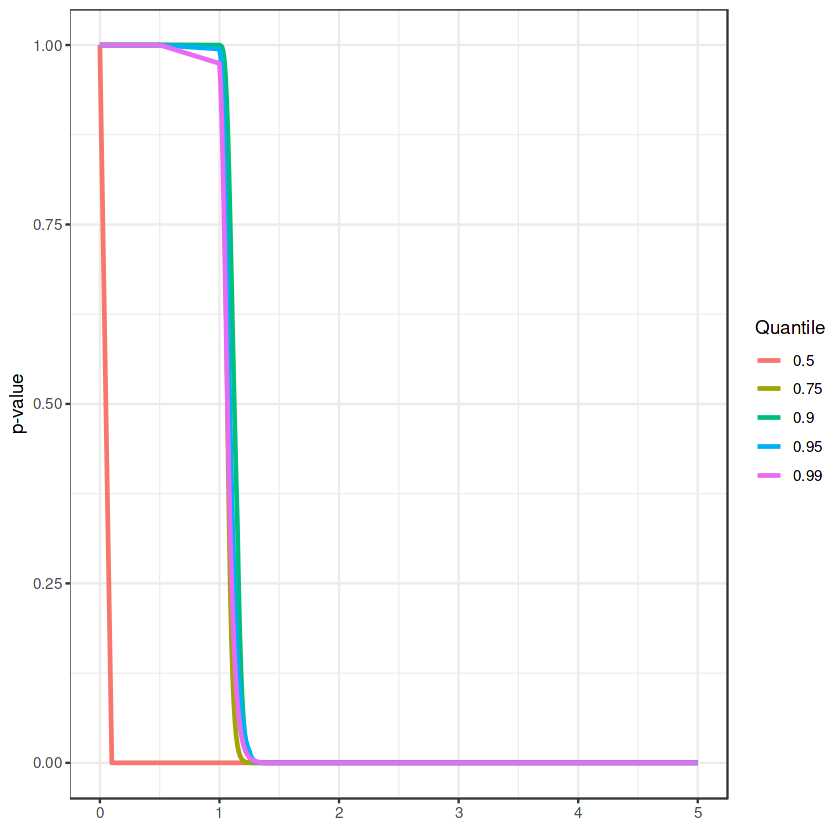

In [9]:
ggplot(df, aes(x = sigma, y = pval, color = as.factor(quant) )) +
    geom_line(linewidth = 1) +
    xlab(expression(sigma)) +
    ylab('p-value') +
    guides(color = guide_legend(title = 'Quantile')) +
    theme_bw()

In [10]:
##################
# simulation of model for H02
# Q(tau, t) = t * (tau, -tau, tau^2 - tau)
##################
n <- 100
p <- 3

sigmas <- c(c(0, 0.1, 0.5), seq(1, 1.5, by = 0.01), c(2, 5))  # increase the error variance to see the effect
quant_levels <- c(0.501, 0.75, 0.9, 0.95, 0.99)
df <- expand.grid(sigma = sigmas, quant = quant_levels)
df$pval <- 0

for (i in 1:nrow(df)) {
    set.seed(1234)
    cat('Iteration: ', i, '\n')
    sigma.err <- df$sigma[i]  # increase the error variance to see the effect
    quant_level <- df$quant[i]

    X <- (1:n)/n  # x-covariate
    U <- runif(n)
    Y.true <- matrix(NA, nrow = n, ncol = p)
    for (j in 1:n) {
        tau <- 2 * U[j] - 1
        Y.true[j, ] <- X[j] * c(tau, -tau, tau^2 - tau)
    }
    err <- matrix(rnorm(n * p), nrow = n, ncol = p)
    Y <- Y.true + sigma.err * err

    res <- test.type2(Y, quant = quant_level, verbose = FALSE)
    df$pval[i] <- res$pvalue
}

write.csv(df, 'hypothesis-sim2.csv')

Iteration:  1 
Iteration:  2 
Iteration:  3 
Iteration:  4 
Iteration:  5 
Iteration:  6 
Iteration:  7 
Iteration:  8 
Iteration:  9 
Iteration:  10 
Iteration:  11 
Iteration:  12 
Iteration:  13 
Iteration:  14 
Iteration:  15 
Iteration:  16 
Iteration:  17 
Iteration:  18 
Iteration:  19 
Iteration:  20 
Iteration:  21 
Iteration:  22 
Iteration:  23 
Iteration:  24 
Iteration:  25 
Iteration:  26 
Iteration:  27 
Iteration:  28 
Iteration:  29 
Iteration:  30 
Iteration:  31 
Iteration:  32 
Iteration:  33 
Iteration:  34 
Iteration:  35 
Iteration:  36 
Iteration:  37 
Iteration:  38 
Iteration:  39 
Iteration:  40 
Iteration:  41 
Iteration:  42 
Iteration:  43 
Iteration:  44 
Iteration:  45 
Iteration:  46 
Iteration:  47 
Iteration:  48 
Iteration:  49 
Iteration:  50 
Iteration:  51 
Iteration:  52 
Iteration:  53 
Iteration:  54 
Iteration:  55 
Iteration:  56 
Iteration:  57 
Iteration:  58 
Iteration:  59 
Iteration:  60 
Iteration:  61 
Iteration:  62 
Iteration:  63 
I

In [11]:
df$quant[df$quant == 0.501] <- 0.5

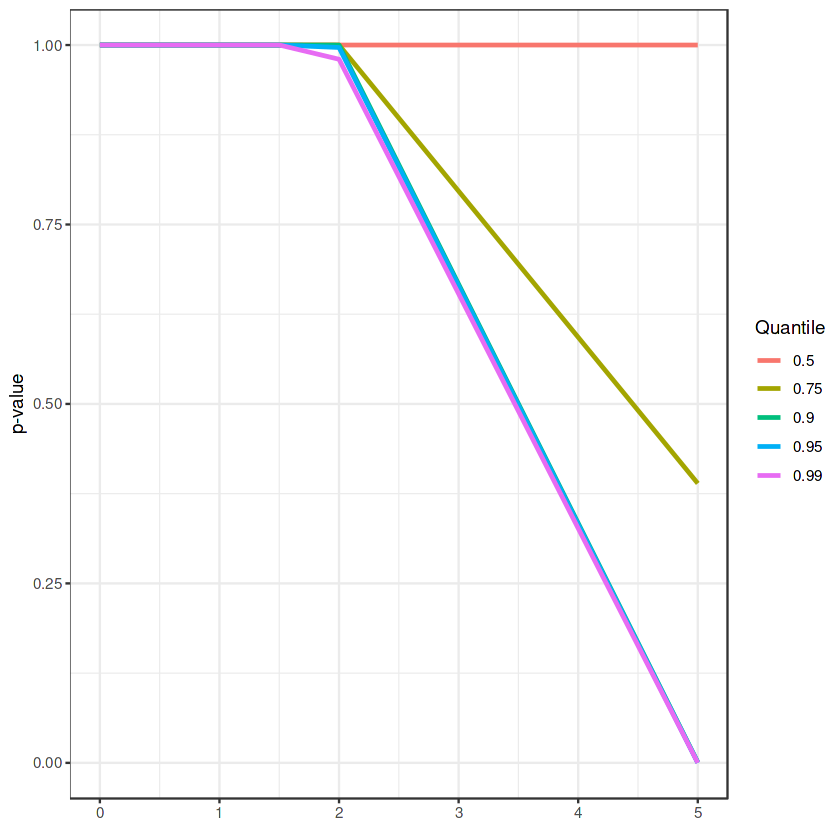

In [12]:
ggplot(df, aes(x = sigma, y = pval, color = as.factor(quant) )) +
    geom_line(linewidth = 1) +
    xlab(expression(sigma)) +
    ylab('p-value') +
    guides(color = guide_legend(title = 'Quantile')) +
    theme_bw()